In [3]:
# loading the python NWB API
import pynwb, os, sys
import numpy as np # numpy for numerical analysis
import matplotlib.pylab as plt # + matplotlib for vizualization

from datavyz import ge
from physion.dataviz.show_data import MultimodalData 
from physion.analysis.read_NWB import scan_folder_for_NWBfiles, DummyParent, read

## Setting the datafolder

In [4]:
FILES, DATES, SUBJECTS = scan_folder_for_NWBfiles(os.path.join(os.path.expanduser('~'), 'DATA', 'fichiers.nwb'))
print('Subjects: ')
for s in np.unique(SUBJECTS):
    print(' -', s)

inspecting the folder "/home/yann/DATA/fichiers.nwb" [...]


 -> found n=56 datafiles 
Subjects: 
 - Mouse1_SSTCreEphys
 - Mouse1_SSTCreTdTomato
 - Mouse2_SSTCreEphys
 - Mouse2_SSTCreTdTomato
 - Mouse3_SSTCreEphys


## Single Recording Analysis

In [5]:

def summary_figure(filename, mouse_name = None, tzoom=[100,120],
                   running_speed_threshold=0.1,
                   median_facemotion_factor=3):
    
    data = MultimodalData(filename)

    if mouse_name is None:
        mouse_name = data.nwbfile.subject.subject_id

    # build full figure
    fig, AX = ge.figure(axes_extents=[[[4,1]],[[4,2]],[[1,1],[1,1],[1,1],[1,1]]], wspace=1.5)
    [ax_full], [ax_zoom], [ax_runningHist, ax_facemvtHist, ax_pupilHist, ax_eyePos] = AX
    
    # running
    ge.hist(data.nwbfile.acquisition['Running-Speed'].data[:], ax=ax_runningHist)

    # full view settings
    plot_settings_full = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=10)},'Tbar':20}
    plot_settings_zoom = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=1)},'Tbar':1}
    
    # whisking
    if 'FaceMotion' in data.nwbfile.processing:
        ge.hist(data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:], ax=ax_facemvtHist)
        plot_settings_full['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=10)
        plot_settings_zoom['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=1)
    else:
        ge.annotate(ax_facemvtHist, 'absent', (0.5, 0.5), ha='center', va='center', size='small')

    # pupil
    if 'Pupil' in data.nwbfile.processing:
        cond = np.isfinite(data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:])
        diameter = np.max([data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[cond],
                data.nwbfile.processing['Pupil'].data_interfaces['sy'].data[cond]], axis=0)
        ge.hist(diameter, ax=ax_pupilHist)
        # eye position
        x = data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond][::10]
        y = data.nwbfile.processing['Pupil'].data_interfaces['cy'].data[cond][::10]
        ge.scatter(x-x.mean(),y-y.mean(), ax=ax_eyePos, color=ge.blue)
        plot_settings_full['settings']['Pupil'] = dict(fig_fraction=1, subsampling=10)
        plot_settings_zoom['settings']['Pupil'] = dict(fig_fraction=1, subsampling=1)

    ge.annotate(fig, mouse_name+'  -- '+filename, (1,1), va='top', ha='right', size='small')

    # full view
    _ = data.plot_raw_data(data.tlim, ax=ax_full, **plot_settings_full)
    ge.annotate(ax_full, 'full recording', (1,1), ha='right', va='top', size='large')
    ax_full.fill_between(tzoom, ax_full.get_ylim()[0]*np.ones(2), ax_full.get_ylim()[1]*np.ones(2),
                        color='gray', alpha=.2, lw=0)
    # zoom
    ge.annotate(ax_zoom, 'zoom', (1,1), ha='right', va='top', size='large')
    _ = data.plot_raw_data(tzoom, ax=ax_zoom, **plot_settings_zoom)

    ge.set_plot(ax_runningHist, yticks=[], ylabel='count (norm.)', xlabel='speed (cm/s)', title='running')
    ge.set_plot(ax_facemvtHist, yticks=[], ylabel='count (norm.)', xlabel='motion (a.u.)', title='whisking')
    ge.set_plot(ax_pupilHist, ylabel='count (norm.)', xlabel='diam. (mm)', title='pupil')
    ge.set_plot(ax_eyePos, xlabel='$\delta$x (mm)', ylabel='$\delta$y (mm)', title='eye position', yscale='lin')

    ax_runningHist.plot(np.ones(2)*running_speed_threshold, ax_runningHist.get_ylim(), ':', color=ge.blue)
    ax_facemvtHist.plot(np.ones(2)*median_facemotion_factor*np.median(data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:]),
                        ax_facemvtHist.get_ylim(), ':', color=ge.purple)

    
    # close datafile
    data.io.close()
    return fig, AX

[163, 102, 513, 547]


/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/datavyz/scatter_plots.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  lw=lw, ms=ms, label=label)


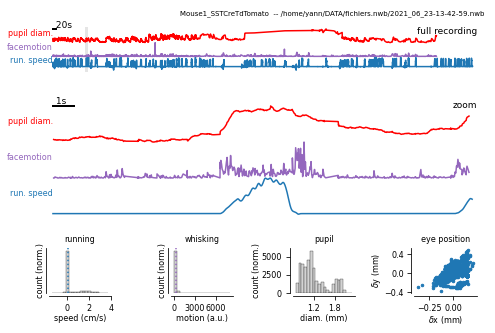

In [6]:
fig, AX = summary_figure(FILES[10], tzoom=[200,220])
#ge.save_on_desktop(fig, 'fig.png')

In [12]:
class Parent:
    def __init__(self):
        pass

def norm_trace(y):
    if y.max()>y.min():
        return (y-y.min())/(y.max()-y.min())
    else:
        return 0*y

def find_non_zero_min(y):
    return np.min(y[y>0])


def analysis(filename,
             running_speed_threshold=0.1,
             pupil_diam_threshold=1.,
             eye_movement_threshold=0.1,
             median_facemotion_factor=3):
    
    data, output = Parent(), {}
    read(data, filename)

    # session duration
    
    # running
    y = data.nwbfile.acquisition['Running-Speed'].data[:]
    running_cond = (y>running_speed_threshold)
    output['percent-running'] = np.sum(running_cond)/len(y)
    output['percent-negative-running'] = 100*np.sum(y<0)/len(y)
    output['mean-running-speed'] = np.mean(y[running_cond])
    
    # facemotion
    if 'FaceMotion' in data.nwbfile.processing:
        y = data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:]
        facemotion_cond = y>median_facemotion_factor*np.median(y)
        output['percent-facemotion'] = 100*np.sum(facemotion_cond)/len(y)
        output['mean-facemotion'] = np.mean(y[facemotion_cond])
    else:
        facemotion_cond = None
        output['percent-facemotion'] = np.inf
        output['mean-facemotion'] = np.inf

    # pupil
    if 'Pupil' in data.nwbfile.processing:
        cond = np.isfinite(data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:])
        diameter = np.max([data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[cond],
                data.nwbfile.processing['Pupil'].data_interfaces['sy'].data[cond]], axis=0)
        output['mean-pupil'] = np.mean(diameter)
        high_pupil_cond = (diameter>pupil_diam_threshold)
        output['percent-high-pupil'] = 100*np.sum(high_pupil_cond)/len(y)
        x0 = np.mean(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond])
        y0 = np.mean(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond])
        eye_mov_cond = (np.abs(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond]-x0)>eye_movement_threshold) & \
            (np.abs(data.nwbfile.processing['Pupil'].data_interfaces['cy'].data[cond]-y0)>eye_movement_threshold)
        output['percent-eye-mov'] = 100*np.sum(eye_mov_cond)/len(eye_mov_cond)
    else:
        high_pupil_cond = None
        output['mean-pupil'] = np.inf
        output['percent-high-pupil'] = np.inf
        output['percent-eye-mov'] = np.inf

    # overlap
    # [...]

    data.io.close()
    return output

output = analysis(FILES[3])
print(output)
    

[64, 246, 604, 527]
{'percent-running': 0.06421176778928056, 'percent-negative-running': 2.4636351723234178, 'mean-running-speed': 1.4166026483859622, 'percent-facemotion': 12.978771200718858, 'mean-facemotion': 435.50372999812635, 'mean-pupil': 0.4422601529833199, 'percent-high-pupil': 0.0, 'percent-eye-mov': 0.14600999606896164}


## Population Analysis of the Habituation Process

In [16]:
def days_per_months(month):
    if month in [2,4,6,9,11]:
        return 30
    else:
        return 31

    
def datestring_to_int(day):
    y, m, d = day.split('_')
    return int(y)*31*12+days_per_months(int(m))+int(d)
    

FILES, DATES, SUBJECTS = scan_folder_for_NWBfiles(os.path.join(os.path.expanduser('~'), 'DATA', 'fichiers.nwb'))

for iS, s in enumerate(np.unique(SUBJECTS)):
    condS = (SUBJECTS==s)
    # re-init results
    results = {}
    for key in ['percent-running', 'percent-negative-running', 'mean-running-speed', 'percent-facemotion',\
                'mean-facemotion', 'mean-pupil', 'percent-high-pupil', 'percent-eye-mov']:
        results[key] = {'day':[], 'val':[]}
    # looping over datafiles
    files, dates = FILES[condS], np.array([datestring_to_int(d) for d in DATES[condS]])
    for ifile in np.argsort(dates):
        output = analysis(files[ifile])
        for key in output:
            if np.isfinite(output[key]):
                results[key]['day'].append(dates[ifile]-dates.min())
                results[key]['val'].append(output[key])
    # plotting
    
    
    


[192, 11, 506, 612]


[163, 102, 513, 547]
[130, 146, 550, 450]
[158, 67, 521, 571]


[149, 114, 525, 540]
[131, 107, 532, 501]
[154, 243, 485, 414]


[64, 154, 573, 480]
[76, 111, 581, 531]
[180, 165, 484, 504]


[103, 216, 565, 438]
[122, 196, 546, 465]


[161, 169, 511, 496]
[126, 134, 542, 519]
[142, 169, 526, 500]


[153, 165, 515, 511]
[313, 247, 368, 617]
[299, 256, 382, 599]
[289, 228, 385, 667]


[180, 42, 449, 581]
[169, 30, 499, 627]


/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


[171, 84, 478, 568]
[238, 57, 454, 565]
[242, 46, 438, 623]
[265, 19, 419, 619]


[279, 61, 397, 573]
[232, 89, 451, 578]


[199, 147, 420, 493]
[220, 186, 445, 423]
[174, 36, 504, 546]


[49, 289, 611, 477]
[41, 250, 627, 515]
[49, 319, 495, 407]


[37, 254, 631, 496]
[22, 239, 635, 531]
[64, 246, 604, 527]


[204, 301, 480, 465]
[223, 285, 449, 477]


[176, 281, 496, 477]
[18, 273, 646, 488]
[53, 262, 615, 500]
[204, 301, 465, 453]


[22, 285, 650, 461]
{'percent-running': {'day': [0, 11, 0, 1, 2, 2, 7, 7, 14, 14, 14, 14, 14, 0, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 6, 6, 6, 7, 7, 7, 11, 11, 11, 13, 13, 0, 1, 5, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], 'val': [0.09581347104519775, 0.11407820679824023, 0.07798175150615559, 0.04140975953492469, 0.2597218250888444, 0.2046712985107297, 0.29969627471641974, 0.2998925042378137, 0.2342203767408732, 0.04417879417879418, 0.2749643587677431, 0.19637253411117409, 0.0, 0.35965580261955526, 0.13714662490727766, 0.13516854858649963, 0.06596765711280568, 0.22891342098734804, 0.0563657863618447, 0.06166269040190861, 0.2615521035173569, 0.3066329213778596, 0.10461722170624917, 0.05483967635600839, 0.32551247221536184, 0.228988603988604, 0.0556879319453579, 0.003482812628802242, 0.0, 0.011959521619135235, 0.046285194525985035, 0.06956088564796659, 0.02241781854997004, 0.15749474417924877, 0.0, 0.01879927228623408, 0.08223353960170125, 0.06906240905578581, 0.11694016432619432, 

# Summary figure

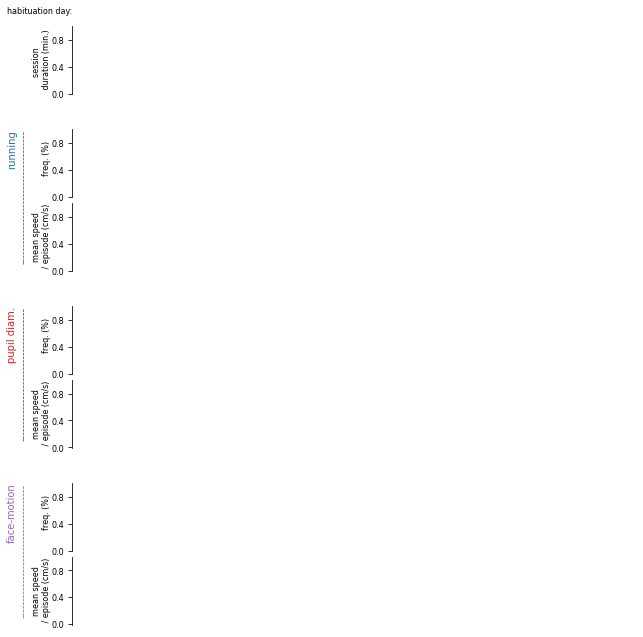

In [33]:
axes_extent=[[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]]]

fig, AX = ge.figure(axes_extents=axes_extent, figsize=(3,.2), hspace=1., left=4., bottom=0., top=5.)
for i in [1, 4, 7]:
    AX[i].axis('off')
for i, label, color in zip([2, 5, 8], ['running', 'pupil diam.', 'face-motion'], ['blue', 'red', 'purple']):
    ge.annotate(AX[i], label + 5*'\n', (0, 1), va='top', ha='right', rotation=90, color=getattr(ge, color), size='x-large')
    ge.annotate(AX[i], 37*'-'+4*'\n', (0, 1), va='top', ha='right', rotation=90, color=getattr(ge, color), size='x-large')

i=0
ge.set_plot(AX[0], ['left'], ylabel='session \n duration (min.)')
i+=2
ge.set_plot(AX[i], ['left'], ylabel='    freq. (%)')
ge.set_plot(AX[i+1], ['left'], ylabel='mean speed\n / episode (cm/s)')
i+=3
ge.set_plot(AX[i], ['left'], ylabel='    freq. (%)')
ge.set_plot(AX[i+1], ['left'], ylabel='mean speed\n / episode (cm/s)')
i+=3
ge.set_plot(AX[i], ['left'], ylabel='    freq. (%)')
ge.set_plot(AX[i+1], ['left'], ylabel='mean speed\n / episode (cm/s)')

ge.annotate(AX[0], 'habituation day: \n', (0, 1.), ha='right')
